In [1]:
class Tax:
    """
    Danish tax calculations (2025)
    Source: https://skat.dk/en-us/help/tax-rates
    """
    LABOR_MARKET_TAX_RATE: float = 0.08
    KOMMUNE_TAX_RATE: float = 0.2457
    BOTTOM_TAX_RATE: float = 0.1201
    TOP_TAX_RATE: float = 0.15
    TOP_TAX_BRACKET_LIMIT: int = 611800
    INCOME_TAX_CEILING: float = 0.5207
    PERSONAL_TAX_ALLOWANCE: int = 51600
    EMPLOYMENT_DEDUCTION_RATE: float = 0.123
    EMPLOYMENT_DEDUCTION_CEILING: int = 55600
    JOB_ALLOWANCE_RATE: float = 0.045
    JOB_ALLOWANCE_THRESHOLD: int = 224500
    JOB_ALLOWANCE_CEILING: float = 2900
    DEDUCTION_TAX_RATE: float = 0.37 # This is the tax rate for deductions

    CAPITAL_GAIN_TAX_RATE: float = 0.27
    CAPITAL_GAIN_GRADUATED_LIMIT: int = 67500
    CAPITAL_GAIN_TAX_GRADUATED_RATE: float = 0.42
    CAPTIAL_GAIN_TAX_CEILING: float = 0.42
    TOP_CAPITAL_INCOME_DEDUCTION_ALLOWANCE: int = 52400

    AKTIESPAREKONTO_LIMIT: int = 166200
    AKTIESPAREKONTO_TAX_RATE: float = 0.17

    @classmethod
    def cal_monthly_tax_deduction_amount(cls, anual_salary: float) -> float:
        """
        Calculate the monthly tax deduction amount based on the personal tax allowance.

        Args:
            anual_salary (float): The annual salary of the individual.
        
        Returns:
            float: The monthly tax deduction amount.
        """
        # Employment deduction
        emp_deduct = anual_salary * cls.EMPLOYMENT_DEDUCTION_RATE
        emp_deduct = min(emp_deduct, cls.EMPLOYMENT_DEDUCTION_CEILING)

        # Job allowance
        job_allowance = max(0, anual_salary - cls.JOB_ALLOWANCE_THRESHOLD) * cls.JOB_ALLOWANCE_RATE
        job_allowance = min(job_allowance, cls.JOB_ALLOWANCE_CEILING)

        # Kommune tax deduction
        total_kommune_deduct = (emp_deduct + job_allowance + cls.PERSONAL_TAX_ALLOWANCE) * cls.KOMMUNE_TAX_RATE

        # Bottom tax deduction
        total_bottom_tax_deduct = cls.PERSONAL_TAX_ALLOWANCE * cls.BOTTOM_TAX_RATE

        # Total tax deduction
        total_tax_deduct = total_kommune_deduct + total_bottom_tax_deduct

        # Convert to equivalent taxable income amount
        total_deduct_amount = total_tax_deduct / cls.DEDUCTION_TAX_RATE

        # Monthly tax deduction
        monthly_tax_deduct = total_deduct_amount / 12

        return round(monthly_tax_deduct)
    
    @classmethod
    def cal_monthly_tax_amount(cls, monthly_salary: float) -> float:
        """
        Calculate the monthly tax amount based on the monthly salary.

        Args:
            monthly_salary (float): The monthly salary of the individual.
        
        Returns:
            float: The monthly tax amount.
        """
        # Monthly labor market tax
        labor_market_tax = monthly_salary * cls.LABOR_MARKET_TAX_RATE
        salary_after_labor_tax = monthly_salary - labor_market_tax

        # Tax deduction amount
        monthly_tax_deduct = cls.cal_monthly_tax_deduction_amount(monthly_salary * 12)
        taxabile_income = salary_after_labor_tax - monthly_tax_deduct

        # Tax
        if taxabile_income <= 0:
            return 0.0
        
        tax_rate = cls.DEDUCTION_TAX_RATE
        tax_rate = tax_rate if tax_rate < cls.INCOME_TAX_CEILING else cls.INCOME_TAX_CEILING
        monthly_tax = taxabile_income * tax_rate

        if taxabile_income > cls.TOP_TAX_BRACKET_LIMIT / 12:
            # Top tax applies
            top_taxable_income = taxabile_income - (cls.TOP_TAX_BRACKET_LIMIT / 12)
            top_tax = top_taxable_income * cls.TOP_TAX_RATE
            monthly_tax += top_tax
            
        return round(monthly_tax, 2)
    
    @classmethod
    def cal_monthly_salary_after_tax(cls, monthly_salary: float) -> float:
        """
        Calculate the monthly salary after tax.

        Args:
            monthly_salary (float): The monthly salary of the individual.
        
        Returns:
            float: The monthly salary after tax.
        """
        # Monthly labor market tax
        labor_market_tax = monthly_salary * cls.LABOR_MARKET_TAX_RATE
        salary_after_labor_tax = monthly_salary - labor_market_tax
        monthly_tax = cls.cal_monthly_tax_amount(monthly_salary)
        return round(salary_after_labor_tax - monthly_tax, 2)
    
    @classmethod
    def cal_annual_capital_gain_tax(cls, capital_gain: float, akties_gain: float) -> float:
        """
        Calculate the annual capital gain tax based on the capital gain amount.

        Args:
            capital_gain (float): The annual capital gain amount.
            akties_gain (float): The annual gain from the Aktiesparekonto.
        
        Returns:
            float: The annual capital gain tax.
        """
        if capital_gain <= cls.CAPITAL_GAIN_GRADUATED_LIMIT:
            tax = capital_gain * cls.CAPITAL_GAIN_TAX_RATE
        else:
            tax = (cls.CAPITAL_GAIN_GRADUATED_LIMIT * cls.CAPITAL_GAIN_TAX_RATE +
                   (capital_gain - cls.CAPITAL_GAIN_GRADUATED_LIMIT) * cls.CAPITAL_GAIN_TAX_GRADUATED_RATE)
        
        # Aktiesparekonto tax
        akties_tax = akties_gain * cls.AKTIESPAREKONTO_TAX_RATE
        tax += akties_tax
        
        return round(tax, 2)
    
    @classmethod
    def cal_annual_akties_gain_tax(cls, akties_gain: float) -> float:
        """
        Calculate the annual tax on gains from the Aktiesparekonto.

        Args:
            akties_gain (float): The annual capital gain amount.
        
        Returns:
            float: The annual tax on gains from the Aktiesparekonto.
        """
        return round(akties_gain * cls.AKTIESPAREKONTO_TAX_RATE, 2)



In [2]:
anual_salary = 588000
Tax.cal_monthly_tax_deduction_amount(anual_salary)

7488

In [3]:
monthly_salary = anual_salary / 12
Tax.cal_monthly_salary_after_tax(monthly_salary)

31170.96

In [4]:
class PersonalFinance:
      
    """
    Personal finance calculations for investment and tax.
    """
    def __init__(self, annual_salary: float, annual_salary_raise: float = 0.03):
        """
        Initialize the personal finance calculator.
        """
        self.annual_salary = annual_salary
        self.annual_salary_raise = annual_salary_raise

    def raise_salary(self):
        """
        Raise the annual salary by the specified percentage.
        """
        self.annual_salary *= (1 + self.annual_salary_raise)

    def get_monthly_net_salary(self) -> float:
        """
        Calculate the monthly net salary after tax.

        Returns:
            float: The monthly net salary.
        """
        monthly_salary = self.annual_salary / 12
        return Tax.cal_monthly_salary_after_tax(monthly_salary)


class InvestmentSimulator:
    """
    Investment simulator for calculating future investment value.
    """

    def __init__(self, 
                pf: PersonalFinance, 
                init_investment: float, 
                invest_percent: float, 
                annual_return: float, 
                months: int,):
        """
        Initialize the investment simulator.

        Args:
            pf (PersonalFinance): The personal finance calculator.
            init_investment (float): Initial investment amount.
            invest_percent (float): Percentage of monthly salary to invest.
            annual_return (float): Expected annual return rate.
            months (int): Number of months to simulate.
        """

        self.pf = pf
        self.init_investment = init_investment
        self.investment_amount = init_investment
        self.invest_percent = invest_percent
        self.annual_return = annual_return
        self.monthly_return = (1 + annual_return) ** (1/12) - 1
        self.months = months

        self.results = []
        self.savings = []

    def simulate(self):
        """
        Simulate the investment growth over the specified months.
        """
        current_investment = self.init_investment
        annual_gain = 0.0
        for month in range(self.months):
            monthly_investment = self.pf.get_monthly_net_salary() * self.invest_percent
            monthly_gain = current_investment * self.monthly_return
            current_investment += monthly_gain
            current_investment += monthly_investment
            self.results.append(round(current_investment, 2))

            # Add the monthly gain to the annual gain for tax calculation
            annual_gain += monthly_gain
            
            # Add the monthly investment to the total investment amount
            self.investment_amount += monthly_investment
            self.savings.append(round(self.investment_amount, 2))

            if month % 12 == 0 and month > 0:
                # Raise salary every year
                self.pf.raise_salary()
                # Deduct tax from the investment gains
                annual_tax = self.compute_annual_tax(current_investment, annual_gain)
                current_investment -= annual_tax
                annual_gain = 0.0     
        
        return self.results
    
    def compute_annual_tax(self, current_investment: float, annual_gain: float) -> float:
        """
        Compute the annual tax on the investment gains.
        
        Returns:
            float: The annual tax on the investment gains.
        """
        if current_investment <= Tax.AKTIESPAREKONTO_LIMIT:
            # If the investment is within the Aktiesparekonto limit, assume all gains are from Aktiesparekonto
            return Tax.cal_annual_akties_gain_tax(annual_gain)
        
        else:
            # If the investment exceeds the Aktiesparekonto limit
            # Calculate the tax on the gains of Aktiesparekonto and the rest
            # from the capital gain tax
            akties_gain = Tax.AKTIESPAREKONTO_LIMIT * self.annual_return
            capital_gain = annual_gain - akties_gain
            return Tax.cal_annual_capital_gain_tax(capital_gain, akties_gain)
        
    
    def print_sim_report(self):
        """
        Print the investment simulation report.
        """
        print(f"Initial Investment: {self.init_investment}")
        print(f"Monthly Investment Percentage: {self.invest_percent * 100}%")
        print(f"Expected Annual Return Rate: {self.annual_return * 100}%")
        print(f"Expected Monthly Return Rate: {self.monthly_return * 100}%")
        print(f"Total Months: {self.months}")
        print("Investment Growth Over Time:")
        for month, value in enumerate(self.results, start=1):
            print(f"Month {month}: {value}")

    

In [ ]:
pf = PersonalFinance(annual_salary=588000, annual_salary_raise=0.03)
investment_simulator = InvestmentSimulator(
    pf=pf, 
    init_investment=180000, 
    invest_percent=0.5, 
    annual_return=0.25, 
    months=240
)

investment_simulator.simulate()
investment_simulator.print_sim_report()

Initial Investment: 180000
Monthly Investment Percentage: 50.0%
Expected Annual Return Rate: 30.0%
Expected Monthly Return Rate: 2.2104450593615876%
Total Months: 240
Investment Growth Over Time:
Month 1: 199564.28
Month 2: 219561.02
Month 3: 239999.78
Month 4: 260890.32
Month 5: 282242.64
Month 6: 304066.93
Month 7: 326373.65
Month 8: 349173.44
Month 9: 372477.2
Month 10: 396296.09
Month 11: 420641.48
Month 12: 445525.0
Month 13: 470958.57
Month 14: 478095.49
Month 15: 504675.02
Month 16: 531842.07
Month 17: 559609.63
Month 18: 587990.98
Month 19: 616999.68
Month 20: 646649.6
Month 21: 676954.92
Month 22: 707930.12
Month 23: 739590.01
Month 24: 771949.73
Month 25: 805024.74
Month 26: 793331.8
Month 27: 827318.23
Month 28: 862055.92
Month 29: 897561.46
Month 30: 933851.83
Month 31: 970944.38
Month 32: 1008856.85
Month 33: 1047607.34
Month 34: 1087214.4
Month 35: 1127696.94
Month 36: 1169074.34
Month 37: 1211366.35
Month 38: 1169146.73
Month 39: 1211892.3
Month 40: 1255582.73
Month 41: 

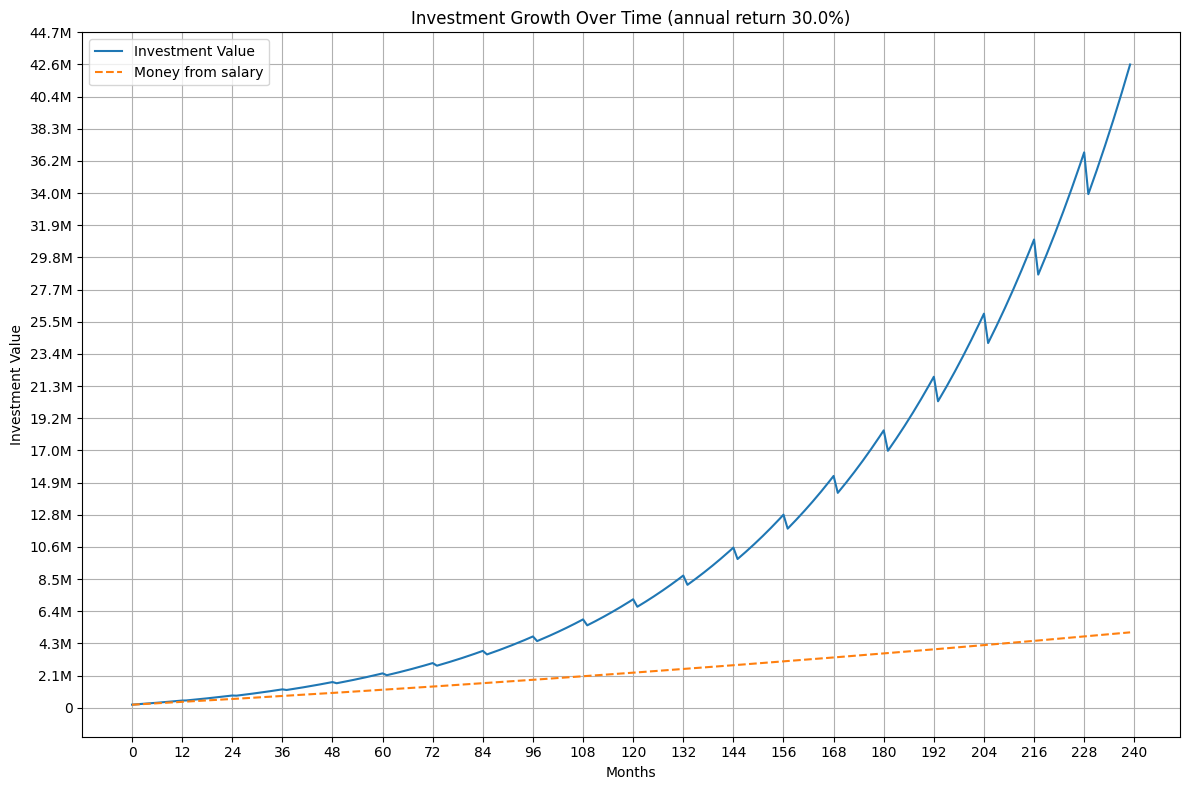

In [6]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# Make the figure bigger
plt.figure(figsize=(12, 8))  # Width=12 inches, Height=8 inches

# Your plotting code
plt.plot(investment_simulator.results, label='Investment Value')
plt.plot(investment_simulator.savings, label='Money from salary', linestyle='--')

# Set more refined axis tickers
# X-axis: Show ticks every 25 months
x_ticks = np.arange(0, 251, 12)  # 0, 25, 50, 75, ..., 250
plt.xticks(x_ticks)

# Y-axis: More refined ticks based on your data range
y_max = max(max(investment_simulator.results), max(investment_simulator.savings))
y_ticks = np.arange(0, y_max * 1.1, y_max * 0.05)  # 10 evenly spaced ticks
plt.yticks(y_ticks)

# Format y-axis to avoid scientific notation
def format_millions(x, pos):
    """Format numbers in millions"""
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_millions))

plt.xlabel('Months')
plt.ylabel('Investment Value')
plt.title(f'Investment Growth Over Time (annual return {investment_simulator.annual_return * 100:.1f}%)')
plt.legend()
plt.grid(True)

# Optional: Adjust layout to prevent clipping
plt.tight_layout()

plt.show()